## Copula Fitting

Once a suitable group stocks have been selected (eg. looking ta correlation, deviation of independence, etc), we must consider how to best fit this data to a vine copula, and how this copula should be applied to generate trading signals that can be tested. 

Note that a copula natively cannot generate future price time series since it treats time series data as independent draws from two random variables, and thus has no information regarding the sequence. One way to think about sampling from a copula trained by time series is that it gives the likelihood of where the next data point is going to be, regardless of the input sequence.

In [34]:
from partner_selection import PartnerSelection
from ps_utils import get_sector_data
import pandas as pd
import pyvinecopulib as pv
import numpy as np
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load returns of selected quadruples
df = pd.read_csv('./data/data.csv', parse_dates=True, index_col='Date').dropna()
df = df['2019-01-01':'2019-12-31'] #Taking 12 month data as mentioned in the paper
ps = PartnerSelection(df)

constituents = pd.read_csv('./data/constituents-detailed.csv', index_col='Symbol')

q = pd.read_csv('./quadruples.csv').to_numpy()
all_returns = ps.get_selected_pair_returns(q)

In [13]:
# Get returns for one quadruple and convert to pseudo observations (normalised ranked)
quadruple = 1
returns = all_returns[quadruple].to_numpy()[1:]
u = pv.to_pseudo_obs(returns)

In [14]:
# We are interested in single parameter families (Gumbel, Clayton, Frank, Joe, Gaussian)
# and Student-t, or any finite mixture of those components
controls = pv.FitControlsVinecop(family_set=[
    pv.gumbel,
    pv.clayton,
    pv.frank,
    pv.joe,
    pv.gaussian,
    pv.student
    ])
cop = pv.Vinecop(u, controls=controls)

In [57]:
# Sample from the copula
num_samples = 251
sim_u = cop.simulate(num_samples, seeds=[1, 2, 3, 4])

d = 4  # copula dimension
# Transform simulation back to the original scale
sim_returns = np.asarray([np.quantile(returns[:, i], sim_u[:, i]) for i in range(0, d)]).T

mean = np.mean(returns, 0)
cov = np.cov(returns)

mean_sim = np.mean(sim_returns, 0)
cov_sim = np.cov(sim_returns)

In [58]:
# Print some info on copula fits
print("C-Vine's respective bivariate copulae:")
pprint(cop.families)
print("Mean returns:")
print(mean)
print("Mean copula-sampled returns:")
print(mean_sim)

C-Vine's respective bivariate copulae:
[[<BicopFamily.clayton: 3>, <BicopFamily.gaussian: 1>, <BicopFamily.gumbel: 4>],
 [<BicopFamily.gaussian: 1>, <BicopFamily.frank: 5>],
 [<BicopFamily.frank: 5>]]
Mean returns:
[-0.05547371  0.02999239  0.09689362  0.02709096]
Mean copula-sampled returns:
[-0.05490021  0.03091374  0.09529137  0.03333247]


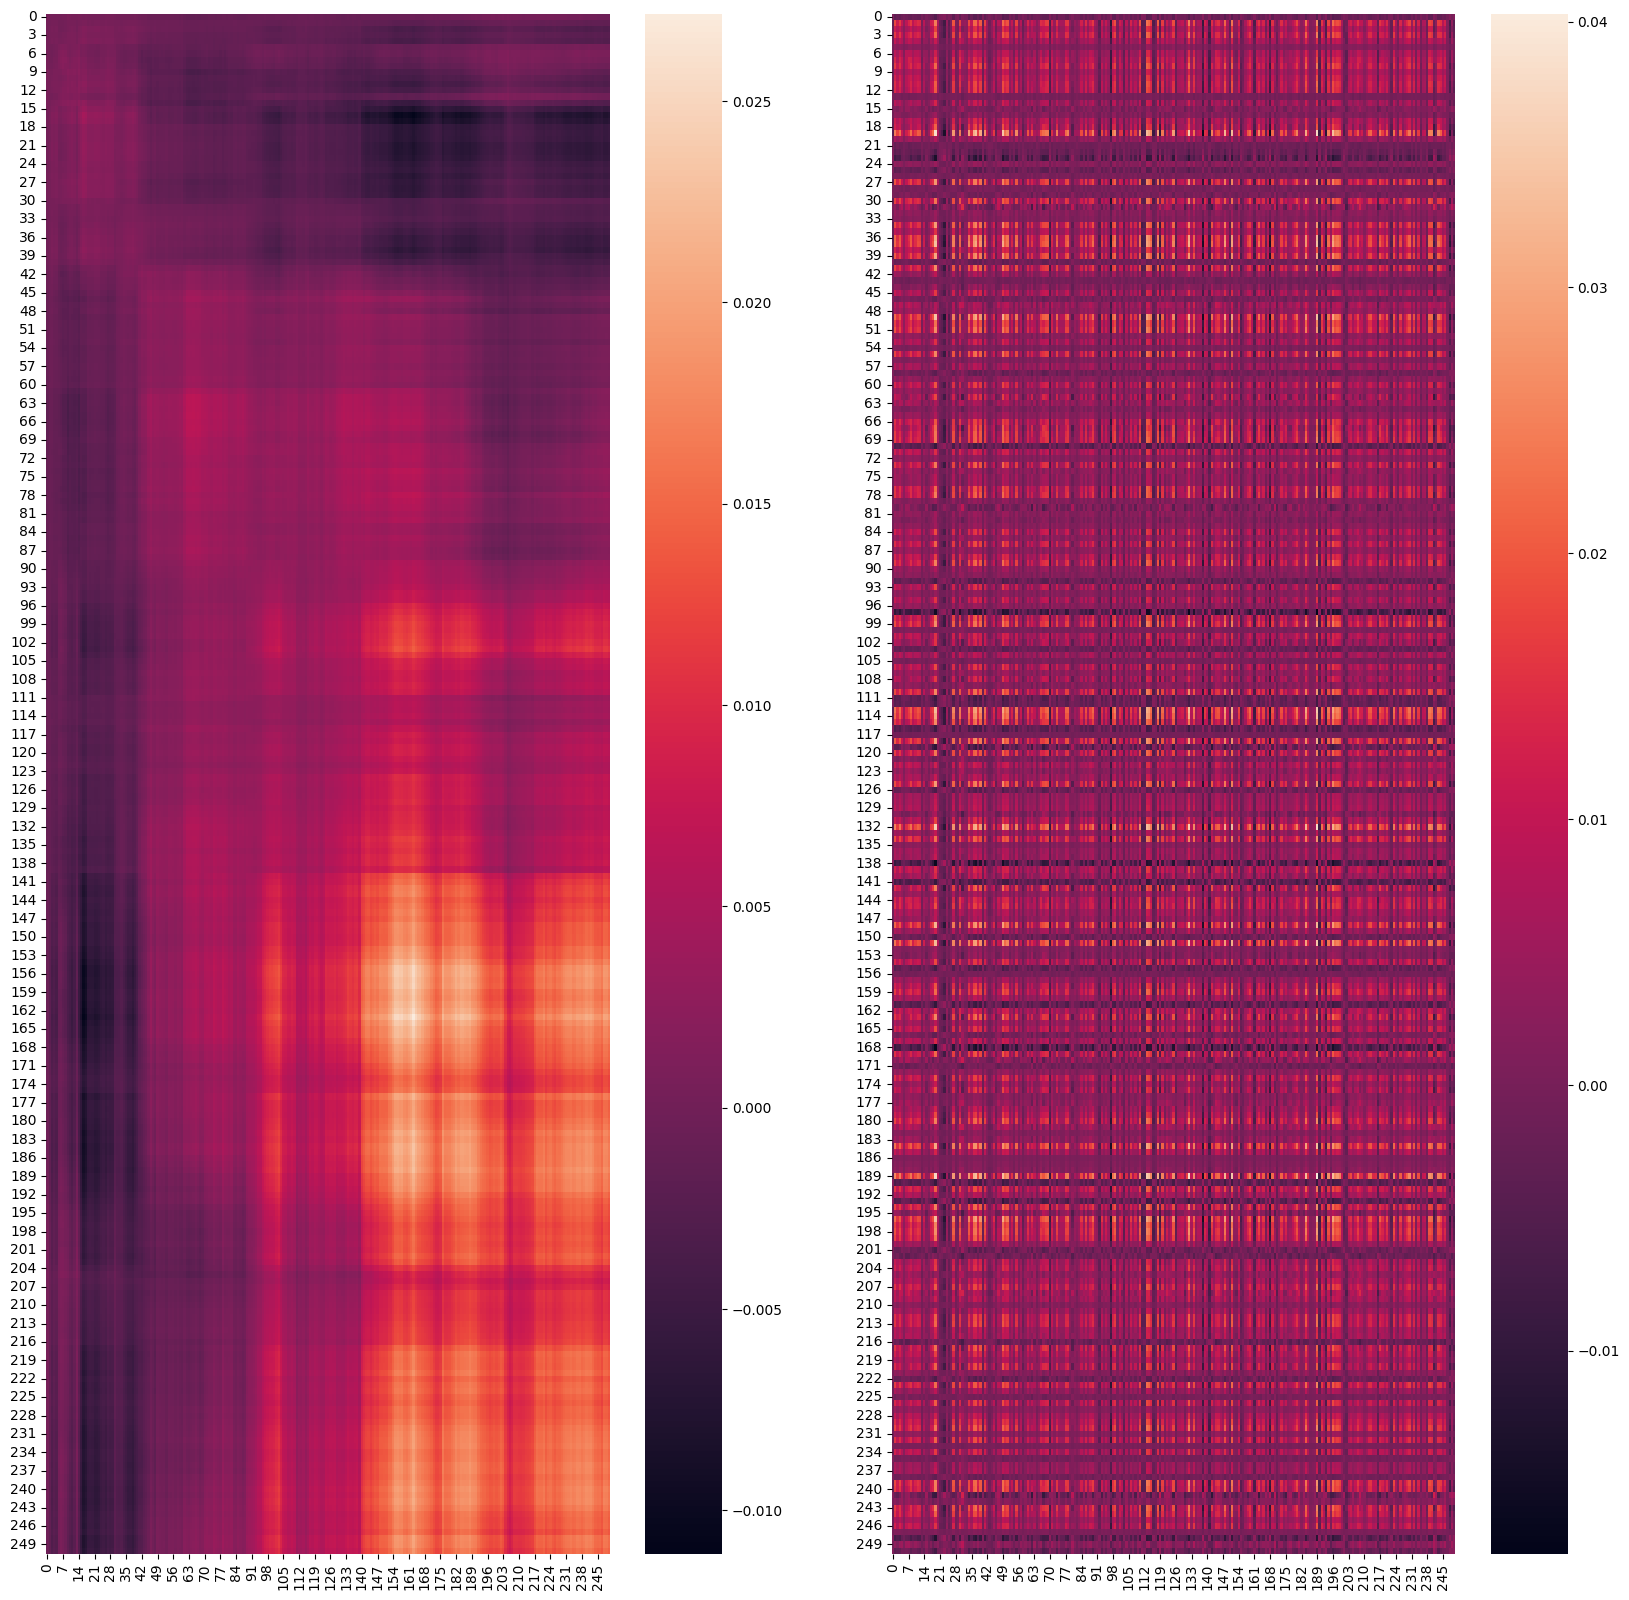

In [59]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(20, 20))
fig.tight_layout(pad=100)
#fig = plt.figure(figsize=(10, 10))
sns.heatmap(cov, ax=ax1)
sns.heatmap(cov_sim, ax=ax2)
plt.show()